**Table of contents**<a id='toc0_'></a>    
- 1. [New-Zealand overview ](#toc1_)    
- 2. [Load datasets](#toc2_)    
  - 2.1. [Load earthquakes](#toc2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>New-Zealand overview  [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load datasets [&#128285;](#toc0_)

## 2.1. <a id='toc2_1_'></a>Load earthquakes [&#128285;](#toc0_)

In [30]:
# Download GNS catalog
# Format
format_usgs = "format=csv"
format_isc = "format=text"  # something that looks like csv

# Date range
t0 = "2010-01-01T00:00:00"
t1 = "2016-01-01T00:00:00"
date_range = f"starttime={t0}&endtime={t1}" 

# Geographic range
minlat = -40
maxlat = -37
minlon = 176
maxlon = 178
geographic_range = f"minlatitude={minlat}&maxlatitude={maxlat}&minlongitude={minlon}&maxlongitude={maxlon}"

# Magnitude range
minmag = 2.2
mag_range = f"minmagnitude={minmag}"

# Event-type
event_type = "eventtype=earthquake"

url = f"https://service.geonet.org.nz/fdsnws/event/1/query?{date_range}&{geographic_range}&{mag_range}&{event_type}&format=text"
print(url)
stream = requests.get(url).content

names = ["id", "time", "lat", "lon", "depth", "author", "catalog", "contributor", "contributor_id", "magtype", "mag", "mag_author", "loc", "type"]
eq = pd.read_csv(io.StringIO(stream.decode('utf-8')), names=names, skiprows=1, delimiter="|")
eq['date'] = pd.to_datetime(eq['time'])
eq = eq.sort_values('date')

https://service.geonet.org.nz/fdsnws/event/1/query?starttime=2010-01-01T00:00:00&endtime=2016-01-01T00:00:00&minlatitude=-40&maxlatitude=-37&minlongitude=176&maxlongitude=178&minmagnitude=2.2&eventtype=earthquake&format=text


## Load tremor

In [31]:
# Load the data
path = workdir + 'projects/data/Catalogs/nz_todd16_1015/nz_tremor_todd16_1015.csv'
names = ['date', 'lat', 'lon']
trm = pd.read_csv(path, names=names, skiprows=1)
trm['date'] = pd.to_datetime(trm['date'])

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_25875/3353285795.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trm['date'] = pd.to_datetime(trm['date'])


In [36]:
# Project onto transect
transect_line = {
    'W': {'lon': 177.050, 'lat':-38.974},
    'E': {'lon': 178.749, 'lat':-37.643}
}

t = transect(trm.lon.values, trm.lat.values, transect_line['W']['lon'], transect_line['W']['lat'], transect_line['E']['lon'], transect_line['E']['lat'])
trm['xf'] = t[0]
trm['yf'] = t[1]

t = transect(eq.lon.values, eq.lat.values, transect_line['W']['lon'], transect_line['W']['lat'], transect_line['E']['lon'], transect_line['E']['lat'])
eq['xf'] = t[0]
eq['yf'] = t[1]
eq_near = eq[(abs(eq['yf']) > 50) & (eq['xf'] > -10)]

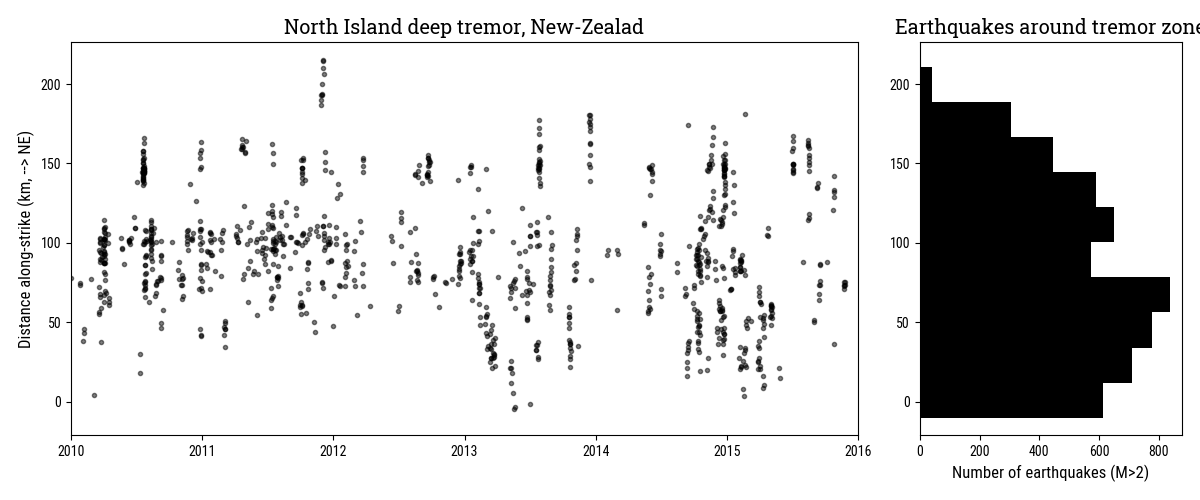

In [41]:
# Show the activity in space and time
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])

ax = fig.add_subplot(gs[0])
ax.set_title('North Island deep tremor, New-Zealad', fontname='Roboto Slab')
ax.set_ylabel('Distance along-strike (km, --> NE)')

ax.plot(trm.date, trm.xf, 'o', color='k', markersize=3, alpha=0.5)

ax.set_xlim(np.datetime64('2010-01-01'), np.datetime64('2016-01-01'))

ax = fig.add_subplot(gs[1], sharey=ax)
ax.set_title('Earthquakes around tremor zone', fontname='Roboto Slab')
ax.set_xlabel('Number of earthquakes (M>2)')

ax.hist(eq_near.xf, bins=10, orientation='horizontal', color='k')

plt.tight_layout()